In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score
)


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



In [2]:
def load_and_bin(csv_path: str) -> pd.DataFrame:
    """
    Load CSV and bin the continuous Anxiety Level into 'low','medium','high'.
    """
    df = pd.read_csv(csv_path)
    bins = [0, 3, 6, 10]
    labels = ['low', 'medium', 'high']
    df['Anxiety_Class'] = pd.cut(
        df['Anxiety Level (1-10)'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )
    return df


In [3]:
def prepare_features(df: pd.DataFrame):
    """
    Split into X/y and apply scaling + one‑hot encoding.
    Returns X_proc, y, preprocessor.
    """
    X = df.drop(columns=['Anxiety Level (1-10)', 'Anxiety_Class'])
    y = df['Anxiety_Class']

    categorical_cols = [
        'Gender', 'Occupation', 'Smoking',
        'Family History of Anxiety', 'Dizziness',
        'Medication', 'Recent Major Life Event'
    ]
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer([
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)
    ])

    X_proc = preprocessor.fit_transform(X)
    return X_proc, y, preprocessor


In [4]:
def resample_and_split(X, y, test_size=0.2, random_state=42):
    """
    Use SMOTE to balance classes, then train/test split.
    """
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X, y)
    return train_test_split(
        X_res, y_res,
        test_size=test_size,
        random_state=random_state,
        stratify=y_res
    )


In [5]:
def train_models(X_train, y_train):
    """
    Train LogisticRegression, SVM, and MLPClassifier.
    Returns a dict of fitted models.
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42, probability=True),
        'Neural Net': MLPClassifier(random_state=42, max_iter=500)
    }
    for m in models.values():
        m.fit(X_train, y_train)
    return models


In [6]:
def evaluate_models(models, X_test, y_test):
    """
    Print classification report, confusion matrix,
    ROC‑AUC and PR‑AUC per class for each model.
    """
    classes = sorted(y_test.unique())
    y_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\n=== {name} ===")
        y_pred = model.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X_test)
            print("ROC AUC:")
            for idx, cls in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, idx], proba[:, idx])
                print(f"  {cls}: {auc(fpr, tpr):.3f}")
            print("PR AUC (Avg Precision):")
            for idx, cls in enumerate(classes):
                precision, recall, _ = precision_recall_curve(y_bin[:, idx], proba[:, idx])
                print(f"  {cls}: {auc(recall, precision):.3f}")
        else:
            print("No probability estimates available.")


In [7]:
def plot_curves(models, X_test, y_test):
    """
    Plot combined ROC and Precision‑Recall curves for all models.
    """
    classes = sorted(y_test.unique())
    y_bin = label_binarize(y_test, classes=classes)

    # ROC
    plt.figure()
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
            plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curves'); plt.legend(); plt.show()

    # Precision‑Recall
    plt.figure()
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X_test)
            precision, recall, _ = precision_recall_curve(y_bin.ravel(), proba.ravel())
            ap = average_precision_score(y_bin, proba)
            plt.plot(recall, precision, label=f'{name} (AP={ap:.2f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision‑Recall Curves'); plt.legend(); plt.show()


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.91      0.93      1040
         low       0.79      0.77      0.78      1041
      medium       0.70      0.75      0.73      1041

    accuracy                           0.81      3122
   macro avg       0.81      0.81      0.81      3122
weighted avg       0.81      0.81      0.81      3122

Confusion Matrix:
[[947   1  92]
 [  2 800 239]
 [ 41 218 782]]
ROC AUC:
  high: 0.989
  low: 0.926
  medium: 0.883
PR AUC (Avg Precision):
  high: 0.983
  low: 0.861
  medium: 0.728

=== SVM ===
Classification Report:
              precision    recall  f1-score   support

        high       0.99      0.95      0.97      1040
         low       0.79      0.76      0.77      1041
      medium       0.73      0.79      0.76      1041

    accuracy                           0.83      3122
   macro avg       0.84      0.83      0.83      3122
weighted avg       0.8

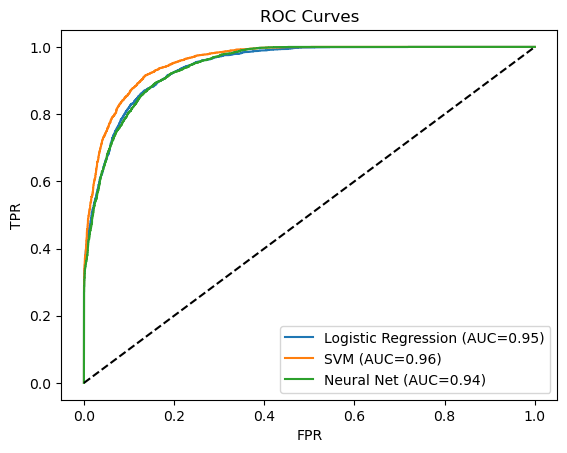

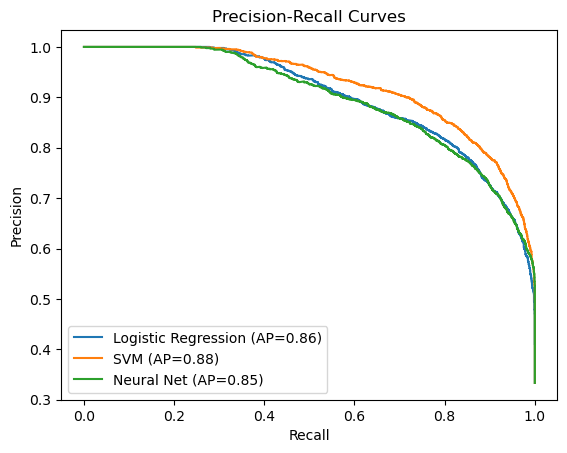

In [8]:
if __name__ == '__main__':
    df = load_and_bin('anxiety.csv')
    X_proc, y, _ = prepare_features(df)
    X_train, X_test, y_train, y_test = resample_and_split(X_proc, y)
    models = train_models(X_train, y_train)
    evaluate_models(models, X_test, y_test)
    plot_curves(models, X_test, y_test)


Training Logistic Regression...
Logistic Regression trained.
Training SVM...
SVM trained.
Training Neural Net...
Neural Net trained.

=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.91      0.93      1040
         low       0.79      0.77      0.78      1041
      medium       0.70      0.75      0.73      1041

    accuracy                           0.81      3122
   macro avg       0.81      0.81      0.81      3122
weighted avg       0.81      0.81      0.81      3122

ROC AUC (macro): 0.9327519676541532
Confusion Matrix:
[[947   1  92]
 [  2 800 239]
 [ 41 218 782]]

=== SVM ===
Classification Report:
              precision    recall  f1-score   support

        high       0.99      0.95      0.97      1040
         low       0.79      0.76      0.77      1041
      medium       0.73      0.79      0.76      1041

    accuracy                           0.83      3122
   macro avg       0.84   

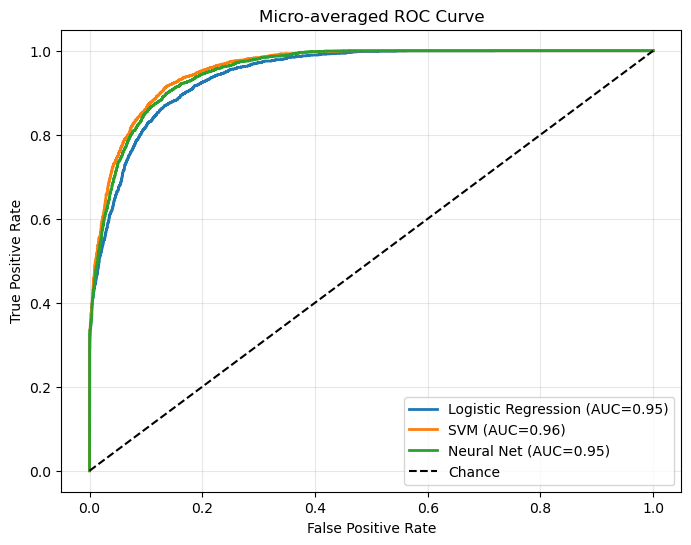

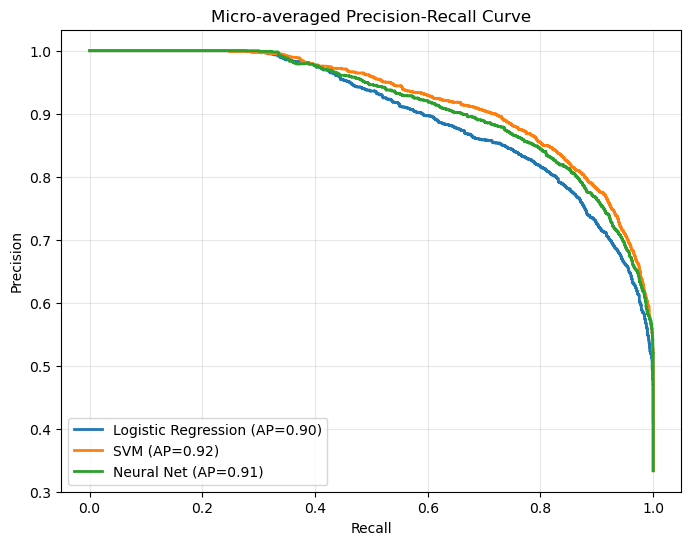

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1) After you’ve done:
# df = load_and_bin('anxiety.csv')
# X_proc, y, preprocessor = prepare_features(df)

# 2) Apply SMOTE to balance the classes
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_proc, y)

# 3) Encode the string labels as integers
le = LabelEncoder()
y_res_enc = le.fit_transform(y_res)
# Now classes are [0,1,2] corresponding to le.classes_ = ['high','low','medium']

# 4) Split into train/test on the encoded labels
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X_res, y_res_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_res_enc
)

# 5) Train your models (MLP with early stopping is now safe)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM':                 SVC(random_state=42, probability=True),
    'Neural Net':          MLPClassifier(
        random_state=42,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        tol=1e-5,
        learning_rate_init=0.001
    )
}

for name, clf in models.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train_enc)
    print(f"{name} trained.")

# 6) Evaluate (decode labels back to strings in the report)
for name, clf in models.items():
    print(f"\n=== {name} ===")
    y_pred_enc = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(
        y_test_enc, y_pred_enc,
        target_names=le.classes_
    ))
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        print("ROC AUC (macro):",
              roc_auc_score(y_test_enc, y_proba, multi_class='ovr'))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_enc, y_pred_enc)
    # (optionally print with decoded labels)
    print(cm)

# 7) Binarize encoded test labels for micro‑avg
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

# 8) Micro‑averaged ROC curve
plt.figure(figsize=(8,6))
for name, clf in models.items():
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})", linewidth=2)

# Chance line
plt.plot([0,1], [0,1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro‑averaged ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 9) Micro‑averaged Precision‑Recall curve
plt.figure(figsize=(8,6))
for name, clf in models.items():
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
        ap = average_precision_score(y_test_bin, y_score, average="micro")
        plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Micro‑averaged Precision‑Recall Curve")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()
    


In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1) Preprocessing (same as before)
# df = load_and_bin('anxiety.csv')
# X_proc, y, preprocessor = prepare_features(df)

# 2) Balance with SMOTE (optional)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_proc, y)

# 3) Encode string labels to integers
le = LabelEncoder()
y_res_enc = le.fit_transform(y_res)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_res_enc
)

# 5) Train models with class_weight='balanced'
models = {
    'LR_balanced': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    'SVM_balanced': SVC(
        class_weight='balanced',
        probability=True,
        random_state=42
    ),
    'MLP': MLPClassifier(
        random_state=42,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        tol=1e-5,
        learning_rate_init=0.001
    )
}

for name, clf in models.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    print(f"{name} trained.")

# 6) Evaluate
for name, clf in models.items():
    print(f"\n=== {name} ===")
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        print("ROC AUC (macro):", roc_auc_score(y_test, y_proba, multi_class='ovr'))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training LR_balanced...
LR_balanced trained.
Training SVM_balanced...
SVM_balanced trained.
Training MLP...
MLP trained.

=== LR_balanced ===
Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.91      0.93      1040
         low       0.79      0.77      0.78      1041
      medium       0.70      0.75      0.73      1041

    accuracy                           0.81      3122
   macro avg       0.81      0.81      0.81      3122
weighted avg       0.81      0.81      0.81      3122

ROC AUC (macro): 0.9327515061160231
Confusion Matrix:
[[947   1  92]
 [  2 800 239]
 [ 41 218 782]]

=== SVM_balanced ===
Classification Report:
              precision    recall  f1-score   support

        high       0.99      0.95      0.97      1040
         low       0.79      0.76      0.77      1041
      medium       0.73      0.79      0.76      1041

    accuracy                           0.83      3122
   macro avg       0.84      0.83    

In [18]:
# 3) Main routine
if __name__ == '__main__':
    # Load and preprocess
    df = load_and_bin('anxiety.csv')
    X_proc, y, _ = prepare_features(df)

    # Encode labels to integers
    le = LabelEncoder()
    y_enc = le.fit_transform(y)  # e.g. ['low','medium','high'] → [0,1,2]

    # Train/test split (no SMOTE)
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc, y_enc,
        test_size=0.2,
        random_state=42,
        stratify=y_enc
    )

    # 4) Instantiate models:
    #    - LR and SVM with class_weight='balanced'
    #    - Neural Net without class weights
    models = {
        'LR_balanced': LogisticRegression(
            class_weight='balanced',
            random_state=42,
            max_iter=1000
        ),
        'SVM_balanced': SVC(
            class_weight='balanced',
            probability=True,
            random_state=42
        ),
        'NeuralNet': MLPClassifier(
            random_state=42,
            max_iter=1000,
            early_stopping=True,
            n_iter_no_change=10,
            tol=1e-5,
            learning_rate_init=0.001
        )
    }

    # 5) Train
    for name, clf in models.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        print(f"{name} trained.")

    # 6) Evaluate
    for name, clf in models.items():
        print(f"\n=== {name} ===")
        y_pred = clf.predict(X_test)
        print("Classification Report:")
        print(classification_report(
            y_test, y_pred,
            target_names=le.classes_
        ))
        if hasattr(clf, 'predict_proba'):
            y_proba = clf.predict_proba(X_test)
            print("ROC AUC (macro):",
                  roc_auc_score(y_test, y_proba, multi_class='ovr'))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

Training LR_balanced...
LR_balanced trained.
Training SVM_balanced...
SVM_balanced trained.
Training NeuralNet...
NeuralNet trained.

=== LR_balanced ===
Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.91      0.85       227
         low       0.82      0.78      0.80      1041
      medium       0.74      0.75      0.75       932

    accuracy                           0.78      2200
   macro avg       0.78      0.81      0.80      2200
weighted avg       0.78      0.78      0.78      2200

ROC AUC (macro): 0.914991292336346
Confusion Matrix:
[[207   0  20]
 [  3 817 221]
 [ 50 185 697]]

=== SVM_balanced ===
Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.90      0.94       227
         low       0.82      0.79      0.80      1041
      medium       0.75      0.80      0.78       932

    accuracy                           0.81      2200
   macro avg       0.85   

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# --- Main ---
df = load_and_bin('anxiety.csv')
X_df = df.drop(columns=['Anxiety Level (1-10)', 'Anxiety_Class'])
y = df['Anxiety_Class']

# Encode labels to integers
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 3. Train/test split (raw X_df)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# 4. Build preprocessor
preprocessor = get_preprocessor(df)

# 5. Define pipelines
svm_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(
        class_weight='balanced',
        probability=True,
        random_state=42,
        C=1.0,           # replace with your tuned C
        kernel='rbf',    # replace with your tuned kernel
        gamma='scale'    # replace with your tuned gamma
    ))
])

mlp_pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier(
        random_state=42,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        tol=1e-5,
        learning_rate_init=0.001
    ))
])

# 6. Voting ensemble (soft)
voting = VotingClassifier(
    estimators=[('svm', svm_pipe), ('mlp', mlp_pipe)],
    voting='soft',
    weights=[1, 2],   # twice the weight on MLP
    n_jobs=-1
)

# 7. Fit ensemble
voting.fit(X_train_df, y_train)

# 8. Evaluate
y_pred = voting.predict(X_test_df)
print("=== Voting Ensemble ===")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
if hasattr(voting, 'predict_proba'):
    y_proba = voting.predict_proba(X_test_df)
    print("ROC AUC (macro):", roc_auc_score(y_test, y_proba, multi_class='ovr'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


=== Voting Ensemble ===
Classification Report:
              precision    recall  f1-score   support

        high       0.94      0.90      0.92       227
         low       0.83      0.74      0.78      1041
      medium       0.72      0.82      0.77       932

    accuracy                           0.79      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.79      0.79      0.79      2200

ROC AUC (macro): 0.9136473938735397
Confusion Matrix:
[[204   0  23]
 [  1 770 270]
 [ 13 159 760]]


In [23]:
#####

In [24]:
#####

In [25]:
####

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1) Load & bin
def load_and_bin(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    bins = [0, 3, 6, 10]
    labels = ['low', 'medium', 'high']
    df['Anxiety_Class'] = pd.cut(
        df['Anxiety Level (1-10)'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )
    return df

# 2) Preprocess features
def prepare_features(df: pd.DataFrame):
    X = df.drop(columns=['Anxiety Level (1-10)', 'Anxiety_Class'])
    y = df['Anxiety_Class']
    categorical_cols = [
        'Gender', 'Occupation', 'Smoking',
        'Family History of Anxiety', 'Dizziness',
        'Medication', 'Recent Major Life Event'
    ]
    numeric_cols = [c for c in X.columns if c not in categorical_cols]
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])
    X_proc = preprocessor.fit_transform(X)
    return X_proc, y, preprocessor

# 3) Handle imbalance & split
def resample_and_split(X, y, test_size=0.2, random_state=42):
    sm = SMOTE(random_state=random_state)
    X_res, y_res = sm.fit_resample(X, y)
    return train_test_split(
        X_res, y_res,
        test_size=test_size,
        random_state=random_state,
        stratify=y_res
    )

# 4) Train base models
def train_models(X_train, y_train):
    """
    Train LogisticRegression, SVM, and MLPClassifier.
    Returns a dict of fitted models.
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM':                  SVC(random_state=42, probability=True),
        'Neural Net':           MLPClassifier(random_state=42, max_iter=500)
    }
    for m in models.values():
        m.fit(X_train, y_train)
    return models

if __name__ == '__main__':
    # Load, preprocess, resample & split
    df = load_and_bin('anxiety.csv')
    X_proc, y, preprocessor = prepare_features(df)
    X_train, X_test, y_train, y_test = resample_and_split(X_proc, y)

    # 5) Feature selection: keep features ≥ median importance
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold='median'
    )
    selector.fit(X_train, y_train)
    X_train_sel = selector.transform(X_train)
    X_test_sel  = selector.transform(X_test)

    # 6) Train on selected features
    models = train_models(X_train_sel, y_train)

    # 7) Evaluate
    # If y is categorical, encode to integers for ROC AUC
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder().fit(y)
    # y_test_sel stays y_test values; assume y is already label-like
    y_test_enc = le.transform(y_test)

    # Binarize for ROC
    y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))

    for name, clf in models.items():
        print(f"\n=== {name} ===")
        y_pred = clf.predict(X_test_sel)
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test_sel)
            print("ROC AUC (macro):",
                  roc_auc_score(y_test_bin, y_proba, multi_class='ovr'))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.91      0.93      1040
         low       0.79      0.77      0.78      1041
      medium       0.71      0.76      0.73      1041

    accuracy                           0.81      3122
   macro avg       0.82      0.81      0.82      3122
weighted avg       0.82      0.81      0.82      3122

ROC AUC (macro): 0.9330195124828139
Confusion Matrix:
[[949   1  90]
 [  3 804 234]
 [ 39 216 786]]

=== SVM ===
Classification Report:
              precision    recall  f1-score   support

        high       0.99      0.92      0.95      1040
         low       0.78      0.75      0.77      1041
      medium       0.70      0.78      0.74      1041

    accuracy                           0.82      3122
   macro avg       0.83      0.82      0.82      3122
weighted avg       0.83      0.82      0.82      3122

ROC AUC (macro): 0.9412859918071662
Confusion Matr